## Task:
Machine Learning model which predicts the overall rating of the beer. (“review/overall”
column in “train.csv” is dependent variable.)

# Features:
index - an identifier for the review
- beer/beerId - a unique ID indicating the beer reviewed
- beer/ABV - the alcohol by volume of the beer
- beer/brewerId - a unique ID indicating the brewery
- beer/name - name of the beer
- beer/style
- review/appearance - rating of the beer's appearance (1.0 to 5.0)
- review/aroma - rating of the beer's aroma (1.0 to 5.0)
- review/overall - rating of the beer overall (1.0 to 5.0)
- review/palate - rating of the beer's palate (1.0 to 5.0)
- review/taste - rating of the beer's taste (1.0 to 5.0)
- review/text - the text of the review
- review/timeStruct - a dict specifying when the review was submitted
- review/timeUnix
- user/ageInSeconds - age of the user in seconds
- user/birthdayRaw
- user/birthdayUnix
- user/gender - gender of the user (if specified)
- user/profileName - profile name of the user


# Metrics

- Mean Absolute Error (MAE)
- R² Score
- F1 Score
- Accuracy
- Custom Precision Score
- Custom Recall Score

#### Experiments Stored in 
```bash
logs/logs.txt
```

In [177]:
# pip install wordcloud
# pip install xgboost

In [178]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import wordcloud

import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,OrdinalEncoder,StandardScaler

from sklearn.metrics import mean_absolute_error,classification_report,accuracy_score,r2_score,f1_score,precision_score,recall_score

from datetime import datetime

from warnings import filterwarnings
filterwarnings('ignore')

random_state = 42
data_path = 'data/train.csv'
target = 'review/overall'

In [179]:
df = pd.read_csv(data_path) # loading the dataset

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              37500 non-null  int64  
 1   beer/ABV           37500 non-null  float64
 2   beer/beerId        37500 non-null  int64  
 3   beer/brewerId      37500 non-null  int64  
 4   beer/name          37500 non-null  object 
 5   beer/style         37500 non-null  object 
 6   review/appearance  37500 non-null  float64
 7   review/aroma       37500 non-null  float64
 8   review/overall     37500 non-null  float64
 9   review/palate      37500 non-null  float64
 10  review/taste       37500 non-null  float64
 11  review/text        37490 non-null  object 
 12  review/timeStruct  37500 non-null  object 
 13  review/timeUnix    37500 non-null  int64  
 14  user/ageInSeconds  7856 non-null   float64
 15  user/birthdayRaw   7856 non-null   object 
 16  user/birthdayUnix  785

# Initially isolating Dataset for Validation

In [181]:
Train_df, Val_df = train_test_split(df, test_size=0.2,shuffle=True,random_state=random_state)

In [182]:
dataset = [Train_df,Val_df]

# EDA

In [183]:
Train_df.describe(include=[int,float])

,index,beer/ABV,beer/beerId,beer/brewerId,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/timeUnix,user/ageInSeconds,user/birthdayUnix
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,6.288000e+03,6.288000e+03
mean,24981.907933,7.398417,21811.703433,3021.089100,3.899683,3.873800,3.888667,3.852933,3.921383,1.232676e+09,1.180978e+09,2.373574e+08
std,14448.107240,2.324835,18914.277832,5093.164827,0.589228,0.681669,0.700218,0.669069,0.714932,7.195219e+07,3.362631e+08,3.362631e+08
min,0.000000,0.100000,175.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,9.262944e+08,7.034366e+08,-2.208960e+09
25%,12401.750000,5.400000,5441.000000,395.000000,3.500000,3.500000,3.500000,3.500000,3.500000,1.188511e+09,9.830270e+08,1.335132e+08
50%,25003.500000,6.900000,17538.000000,1199.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.248062e+09,1.102601e+09,3.157344e+08
75%,37433.250000,9.400000,34146.000000,1315.000000,4.500000,4.500000,4.500000,4.500000,4.500000,1.291171e+09,1.284822e+09,4.353084e+08
max,49999.000000,57.700000,77207.000000,27797.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.326267e+09,3.627295e+09,7.148988e+08


In [184]:
Train_df.describe(include=[object])

,beer/name,beer/style,review/text,review/timeStruct,user/birthdayRaw,user/gender,user/profileName
count,30000,30000,29992,30000,6288,12306,29995
unique,1540,95,29986,29996,1340,2,6761
top,Founders Breakfast Stout,American Double / Imperial Stout,Bought a bottle of this from the brewery the o...,"{'min': 0, 'hour': 0, 'mday': 12, 'sec': 1, 'y...","Sep 14, 1980",Male,northyorksammy
freq,1512,3583,2,2,58,12114,110


In [185]:
(lambda shape: print(f"No. of rows: {shape[0]} & columns: {shape[1]}"))(Train_df.shape)

No. of rows: 30000 & columns: 19


# Missing Values

In [186]:
(lambda percent: print(f"Missing Values Percentage: \n{percent}"))(Train_df.isnull().sum()*100 // len(Train_df))

Missing Values Percentage: 
index                 0
beer/ABV              0
beer/beerId           0
beer/brewerId         0
beer/name             0
beer/style            0
review/appearance     0
review/aroma          0
review/overall        0
review/palate         0
review/taste          0
review/text           0
review/timeStruct     0
review/timeUnix       0
user/ageInSeconds    79
user/birthdayRaw     79
user/birthdayUnix    79
user/gender          58
user/profileName      0
dtype: int64


In [187]:
drop_list = set()

# Data Types

In [188]:
Train_df.dtypes

index                  int64
beer/ABV             float64
beer/beerId            int64
beer/brewerId          int64
beer/name             object
beer/style            object
review/appearance    float64
review/aroma         float64
review/overall       float64
review/palate        float64
review/taste         float64
review/text           object
review/timeStruct     object
review/timeUnix        int64
user/ageInSeconds    float64
user/birthdayRaw      object
user/birthdayUnix    float64
user/gender           object
user/profileName      object
dtype: object

**Inference:** Many features have incorrect datatypes, Therefore neccessary to focus on data type correction together.

# Unique

In [189]:
(lambda x : print(f"No of unique values in each feature: \n{x}"))(Train_df.nunique())

No of unique values in each feature: 
index                30000
beer/ABV               124
beer/beerId           1575
beer/brewerId          202
beer/name             1540
beer/style              95
review/appearance       10
review/aroma             9
review/overall          10
review/palate            9
review/taste             9
review/text          29986
review/timeStruct    29996
review/timeUnix      29996
user/ageInSeconds     1372
user/birthdayRaw      1340
user/birthdayUnix     1340
user/gender              2
user/profileName      6761
dtype: int64


# Feature Analysis

# Target Feature: Ratings (review/overall)

count    30000.000000
mean         3.888667
std          0.700218
min          0.000000
25%          3.500000
50%          4.000000
75%          4.500000
max          5.000000
Name: review/overall, dtype: float64
Skewness -1.0535605638664607


<Axes: xlabel='review/overall', ylabel='Count'>

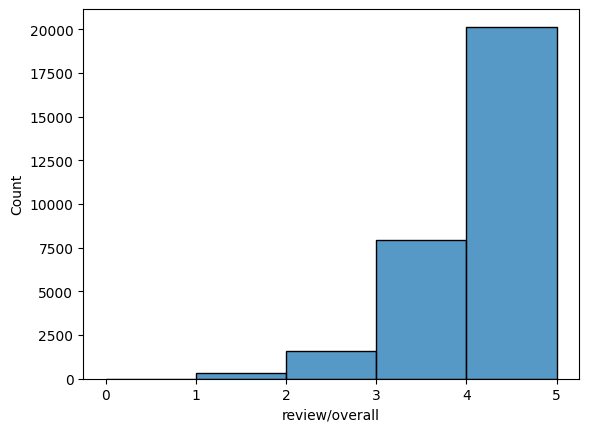

In [190]:
print(Train_df[target].describe())
print('Skewness',Train_df[target].skew() )# highly -ve skewed shows good rating of beers
sns.histplot(Train_df[target],bins=5) # 5 level rating(0-5), therefore taking bin size as 5



### Inferences
- **High Ratings Dominance**: The distribution is left-skewed, suggesting that a substantial number of ratings are above average. This skew may influence the model to better perform on high ratings and underperform on low ratings.




In [191]:
bins = [0, 2.5, 4, np.inf]
labels = ['Low', 'Medium', 'High']

# Create a new column for binned ratings
for data in dataset:
	data['rating/overall/bin'] = pd.cut(data['review/overall'], bins=bins, labels=labels, right=False)

<Axes: xlabel='rating/overall/bin', ylabel='Count'>

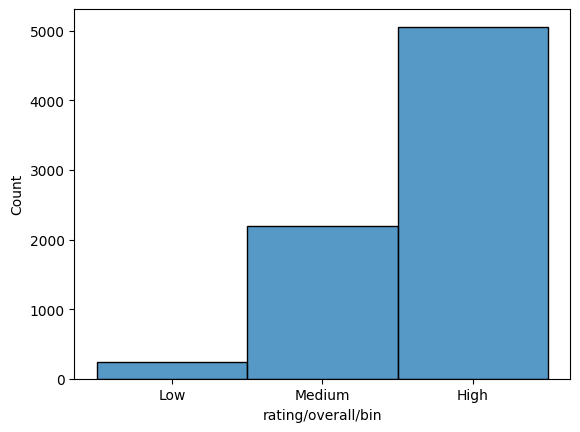

In [192]:
sns.histplot(data['rating/overall/bin'])

# Feature: index

In [193]:
Train_df['index'].nunique()

30000

**Inference :** It is a unique Id assigned to each observation, not providing any info for further analysis. Therefore we will drop it.

In [194]:
drop_list.add('index')

# Feature: beer/ABV  

count    30000.000000
mean         7.398417
std          2.324835
min          0.100000
25%          5.400000
50%          6.900000
75%          9.400000
max         57.700000
Name: beer/ABV, dtype: float64
Skewness: 1.0747260286417017


<Axes: ylabel='beer/ABV'>

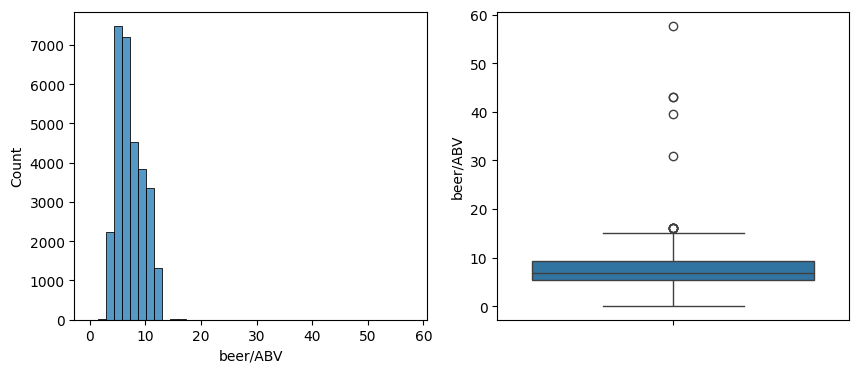

In [195]:
print(Train_df['beer/ABV'
].describe())
print('Skewness:',Train_df['beer/ABV'].skew())
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10,4)
sns.histplot(Train_df['beer/ABV'],bins=40,ax=ax[0])
sns.boxplot(Train_df['beer/ABV'],ax=ax[1])

### Inferences
- Most of the beers have low to high Alcohol content.
- **Predictive Potential**: Higher ABV levels could correlate with specific beer types (e.g., stouts, IPAs) and, therefore, might impact overall ratings.
- **Potential Binning**: If treating this feature categorically, consider binning into categories like **Low (0–4%), Medium (4–8%), High (8–12%)**, and **Very High (>12%)** ABV to capture effects on rating without the influence of outliers.


In [196]:
bins = [0, 5 ,7 , 9, np.inf]
labels = ['Low', 'Medium', 'High','Very High']

for data in dataset:
    data['beer/ABV/bin'] = pd.cut(data['beer/ABV'], bins=bins, labels=labels, right=False)

beer/ABV/bin
Medium       11128
Very High     8506
High          6383
Low           3983
Name: count, dtype: int64


<Axes: ylabel='beer/ABV/bin'>

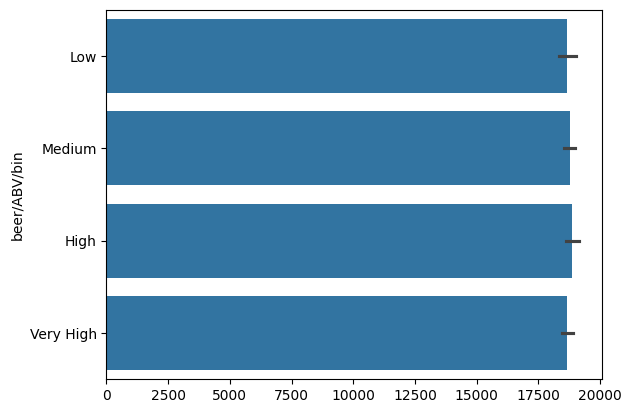

In [197]:
print(Train_df['beer/ABV/bin'].value_counts())
sns.barplot(Train_df['beer/ABV/bin'])

# Feature: beer/beerId & beer/brewerId


In [198]:
(lambda x : print(f"No. of unique values in each beer/beerId: {x[0]} & beer/brewerId: {x[1]}"))(Train_df[['beer/beerId','beer/brewerId']].nunique())

No. of unique values in each beer/beerId: 1575 & beer/brewerId: 202


In [199]:
for data in dataset:
	# both features are categorical variable therefore converted to category
	data['beer/beerId'] = data['beer/beerId'].astype('category')
	data['beer/brewerId'] = data['beer/brewerId'].astype('category')

In [200]:
Train_df[['beer/beerId','beer/brewerId']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 31243 to 15795
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   beer/beerId    30000 non-null  category
 1   beer/brewerId  30000 non-null  category
dtypes: category(2)
memory usage: 405.8 KB


In [201]:
Train_df.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName',
       'rating/overall/bin', 'beer/ABV/bin'],
      dtype='object')

# Feature: **beer/name & beer/style**

In [202]:
word_cloud_generator = wordcloud.WordCloud()

In [203]:
# stopwords = load_json(open('./data/config.json','r'))

In [204]:
custom_stopwords = [
    "a", "about", "above", "after", "again", "against", "all", "also", "am", "an", "and", "any", "are", "as", 
    "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "can", "did", 
    "do", "does", "doing", "don", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
    "have", "having", "he", "her", "here", "hers", "him", "himself", "his", "how", "i", "if", "in", "into", 
    "is", "it", "its", "itself", "just", "like", "me", "more", "most", "my", "myself",  "now", 
    "of", "off", "on", "once", "one", "only", "or", "other", "our", "ours", "ourselves", "out", "over", 
    "own", "same", "she", "should", "so", "some", "such", "than", "that", "the", "their", "theirs", "them", 
    "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "up", 
    "was", "we", "were", "what", "when", "where", "which", "while", "who", "whom", "why", "with", "would", 
    "you", "your", "yours", "yourself", "yourselves"
]

In [205]:
def string_preprocess(text):
    text = text.lower()
    text_list = text.split(' ')
    text = ''
    for word in text_list:
        if (word not in custom_stopwords) and (len(word) > 2):
                text = text + ' ' + word
                        
    text = re.sub(pattern="""[!@#$%^&*()_<>:'\\//.,:";'"{}]""",repl=' ',string=text)
    return text

In [206]:
(lambda x : print(f"No. of unique values in each beer/name: {x[0]} & beer/style: {x[1]}"))(Train_df[['beer/name','beer/style']].nunique())

No. of unique values in each beer/name: 1540 & beer/style: 95


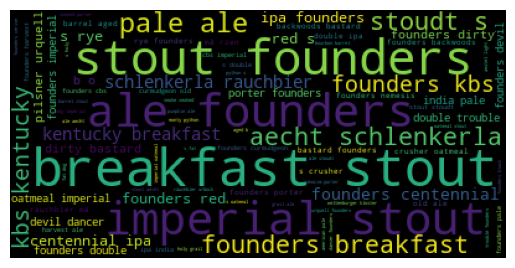

In [207]:
Train_df['prep/beer/name'] = Train_df['beer/name'].apply(string_preprocess)
fig = word_cloud_generator.generate((Train_df['prep/beer/name']+' ').sum() )
plt.imshow(fig, )
plt.axis("off")
plt.show()

In [208]:
Train_df['prep/beer/name'].sample(5)

23827     frosted frog christmas ale
4161                 pilsner urquell
14582            bodacious black tan
6548               founders pale ale
22156        founders double trouble
Name: prep/beer/name, dtype: object

**Inference :** The word cloud indicates a strong preference for Founders beers, particularly their Imperial Stout and Breakfast Stout varieties. There's also a notable interest in Kentucky Common and Pale Ale styles.









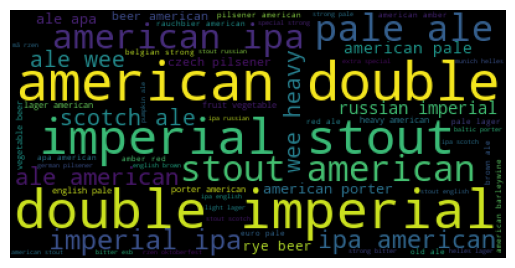

In [209]:
Train_df['prep/beer/style'] = Train_df['beer/style'].apply(string_preprocess)
fig = word_cloud_generator.generate((Train_df['prep/beer/style']+' ').sum() )
plt.imshow(fig, )
plt.axis("off")
plt.show()

**Inference:** The word cloud suggests a strong preference for American beer styles, with a particular emphasis on Imperial Stouts and Double IPAs. There's also a notable interest in Pale Ales and Porters.

In [210]:
for data in dataset:
	data['review/year']  = data['review/timeStruct'].apply(lambda x: eval(x)['year'])
	data['review/month']  = data['review/timeStruct'].apply(lambda x: eval(x)['mon'])

 **Inference :** **user/birthdayRaw** has alot of missing values therefore taking these features for futher analysis will not give much information.
 

# Feature: Review Text

In [211]:
for data in dataset:
    data['review/text'] = data['review/text'].apply(str)

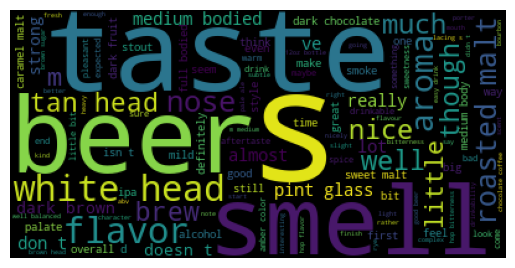

In [212]:
Train_df['prep/review/text'] = Train_df['review/text'].apply(string_preprocess)
fig = word_cloud_generator.generate((Train_df['prep/review/text']+' ').sum() )
plt.imshow(fig, )
plt.axis("off")
plt.show()

**Inference :** The word cloud indicates a strong focus on the sensory experience of beer, with words like "taste," "smell," "flavor," and "mouthfeel" being prominent. There's also an emphasis on the visual aspects of beer, with words like "head," "color," and "glass" appearing frequently. The overall impression is that the reviews are highly detailed and focus on the nuances of the beer drinking experience.

<Axes: xlabel='review/text', ylabel='Count'>

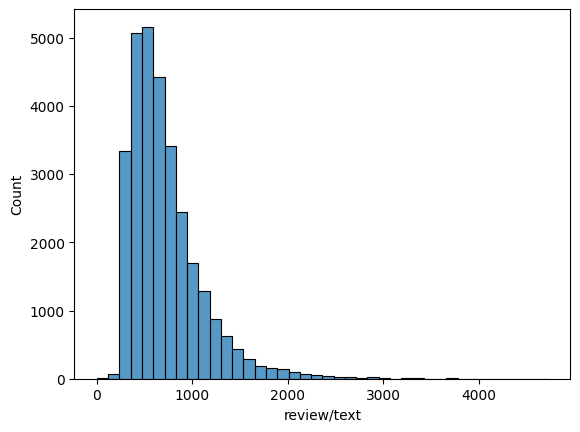

In [213]:
sns.histplot(Train_df['review/text'].apply(len),bins=40)

In [214]:
for data in dataset: 
	data['review/text_len'] = data['review/text'].apply(len)

**Inference :**  The histogram suggests that the review lengths vary significantly, with a majority of reviews being shorter and a few being very long.

In [215]:
for data in dataset: # combining information from review/text, beer/name, beer/style
    data['review/keywords'] = data['review/text'] + ' ' + data['beer/name'] + ' ' + data['beer/style']
    data['review/keywords'] = data['review/keywords'].apply(string_preprocess)

# Features: 'review/appearance', 'review/aroma', 'review/overall','review/palate', 'review/taste'

       review/appearance  review/aroma  review/palate  review/taste
count       30000.000000  30000.000000   30000.000000  30000.000000
mean            3.899683      3.873800       3.852933      3.921383
std             0.589228      0.681669       0.669069      0.714932
min             0.000000      1.000000       1.000000      1.000000
25%             3.500000      3.500000       3.500000      3.500000
50%             4.000000      4.000000       4.000000      4.000000
75%             4.500000      4.500000       4.500000      4.500000
max             5.000000      5.000000       5.000000      5.000000

Skewness:
review/appearance   -0.806201
review/aroma        -0.841106
review/palate       -0.852936
review/taste        -1.000855
dtype: float64


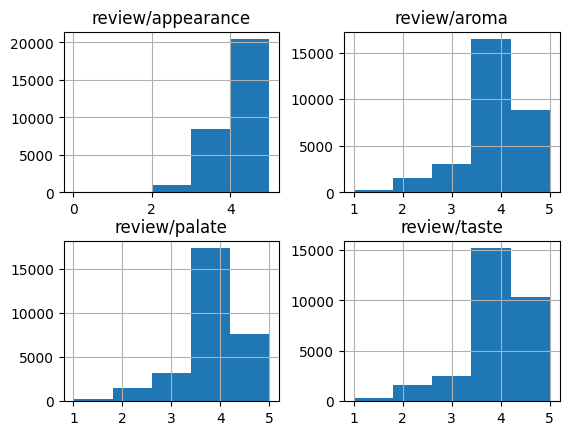

In [216]:
print(Train_df[['review/appearance', 'review/aroma', 
       'review/palate', 'review/taste']].describe())
print('\nSkewness:')
print(Train_df[['review/appearance', 'review/aroma', 
       'review/palate', 'review/taste']].skew())
Train_df[['review/appearance', 'review/aroma', 
       'review/palate', 'review/taste']].hist(bins=5)
plt.show()


**Key Observations:**

* **Overall Positive Ratings:** The majority of ratings are clustered around 4, suggesting that most beers are perceived as being of good quality.
* **Similar Distributions:** The histograms show that the distributions of ratings for appearance, aroma, palate, and taste are quite similar, with peaks around 4 and tails extending towards higher ratings.
* **Slight Variations:** There are some little differences in the distributions. For example, the distribution for taste seems to be slightly more skewed towards higher ratings compared to the other dimensions.

**Potential Insights:**

* **Importance of Appearance:** Appearance seems to be a crucial factor in beer evaluation, with a relatively high mean rating and a tight distribution.
* **Aroma and Taste as Key Differentiators:** While all dimensions are important, aroma and taste might be the most influential factors in determining a beer's overall quality, as evidenced by the slightly higher mean ratings and wider distributions compared to appearance and palate.

Overall, the analysis suggests that beer reviews tend to be positive, with a focus on the sensory qualities of the beverage. 
This proved our previous findings from wordcloud.


# Features: 'review/timeStruct','review/timeUnix',

In [217]:
Train_df[['review/timeStruct',
       'review/timeUnix',]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 31243 to 15795
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review/timeStruct  30000 non-null  object
 1   review/timeUnix    30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 703.1+ KB


In [218]:
Train_df['review/timeStruct'].apply(eval)


31243    {'min': 37, 'hour': 14, 'mday': 10, 'sec': 15,...
36885    {'min': 34, 'hour': 19, 'mday': 18, 'sec': 49,...
37423    {'min': 14, 'hour': 0, 'mday': 16, 'sec': 57, ...
6148     {'min': 2, 'hour': 5, 'mday': 8, 'sec': 10, 'y...
23245    {'min': 27, 'hour': 4, 'mday': 2, 'sec': 14, '...
                               ...                        
16850    {'min': 8, 'hour': 0, 'mday': 11, 'sec': 47, '...
6265     {'min': 55, 'hour': 23, 'mday': 23, 'sec': 14,...
11284    {'min': 18, 'hour': 2, 'mday': 11, 'sec': 20, ...
860      {'min': 16, 'hour': 16, 'mday': 30, 'sec': 13,...
15795    {'min': 49, 'hour': 15, 'mday': 10, 'sec': 43,...
Name: review/timeStruct, Length: 30000, dtype: object

In [219]:
pd.to_datetime(Train_df['review/timeUnix'],origin='unix',unit='s')


31243   2008-05-10 14:37:15
36885   2009-12-18 19:34:49
37423   2003-07-16 00:14:57
6148    2010-12-08 05:02:10
23245   2012-01-02 04:27:14
                ...        
16850   2009-05-11 00:08:47
6265    2011-09-23 23:55:14
11284   2006-09-11 02:18:20
860     2007-12-30 16:16:13
15795   2010-02-10 15:49:43
Name: review/timeUnix, Length: 30000, dtype: datetime64[ns]

We can see that both feature has same type of data in different format therefore good to drop one.

In [220]:
drop_list.add('review/timeStruct')

In [221]:
for data in dataset:
	data['review/Datetime'] = pd.to_datetime(data['review/timeUnix'],origin='unix',unit='s')

In [222]:
for data in dataset:
	data['review/year'] = data['review/Datetime'].dt.year
	data['review/month'] = data['review/Datetime'].dt.month
	data['review/date'] = data['review/Datetime'].dt.date


<Axes: xlabel='review/year', ylabel='review/overall'>

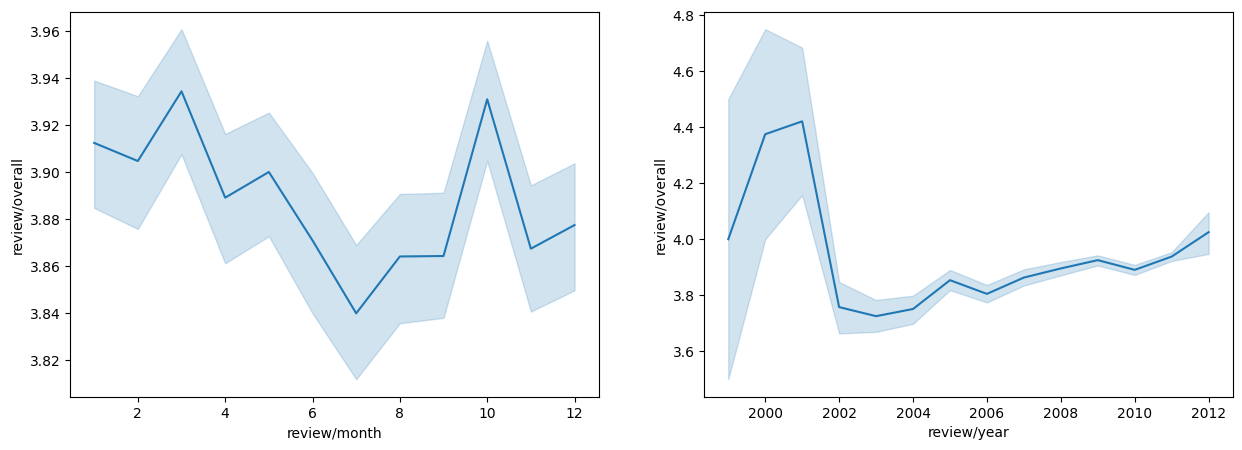

In [223]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
sns.lineplot(data=Train_df,x='review/month',y='review/overall',ax=ax[0])
sns.lineplot(data=Train_df,x='review/year',y='review/overall',ax=ax[1])

The provided plots indicate that beer ratings fluctuate both monthly and annually. While the monthly variations are less pronounced, the yearly trend shows a significant dip around 2004-2005 followed by a recovery.

In [224]:
Train_df.columns

Index(['index', 'beer/ABV', 'beer/beerId', 'beer/brewerId', 'beer/name',
       'beer/style', 'review/appearance', 'review/aroma', 'review/overall',
       'review/palate', 'review/taste', 'review/text', 'review/timeStruct',
       'review/timeUnix', 'user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix', 'user/gender', 'user/profileName',
       'rating/overall/bin', 'beer/ABV/bin', 'prep/beer/name',
       'prep/beer/style', 'review/year', 'review/month', 'prep/review/text',
       'review/text_len', 'review/keywords', 'review/Datetime', 'review/date'],
      dtype='object')

# Features: 'user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix',

In [225]:
Train_df[['user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix',]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 31243 to 15795
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user/ageInSeconds  6288 non-null   float64
 1   user/birthdayRaw   6288 non-null   object 
 2   user/birthdayUnix  6288 non-null   float64
dtypes: float64(2), object(1)
memory usage: 937.5+ KB


In [226]:
(lambda percent: print(f"Missing Values Percentage: \n{percent}"))(Train_df[['user/ageInSeconds', 'user/birthdayRaw',
       'user/birthdayUnix',]].isnull().sum()*100 // len(Train_df))

Missing Values Percentage: 
user/ageInSeconds    79
user/birthdayRaw     79
user/birthdayUnix    79
dtype: int64


**Inference :** The features user/ageInSeconds, user/birthdayRaw, and user/birthdayUnix exhibit a high percentage of missing values, suggesting that this information was not consistently recorded. As these features are likely to have limited impact on beer rating prediction, it is good to drop them from the dataset.

In [227]:
drop_list.update(['user/ageInSeconds', 'user/birthdayRaw', 'user/birthdayUnix'])

# Feature: 'user/gender'

In [228]:
Train_df['user/gender'].value_counts(dropna=False)

user/gender
NaN       17694
Male      12114
Female      192
Name: count, dtype: int64

Gender feature also have alot of missing values but we can consider these as another category "Not disclosed" instead of droping the feature.

In [229]:
for data in dataset:
	data['user/gender/new'] = data['user/gender'].fillna("Not disclosed")

# Feature: 'user/profile/Name'

In [230]:
print("Unique values in user/profileName",Train_df['user/profileName'].nunique())
print("Top 5 Customers who have given more review\n",Train_df['user/profileName'].value_counts().head(10))


Unique values in user/profileName 6761
Top 5 Customers who have given more review
 user/profileName
northyorksammy     110
BuckeyeNation       86
akorsak             72
mikesgroove         71
ChainGangGuy        67
oberon              66
Thorpe429           65
barleywinefiend     63
smcolw              63
MasterSki           60
Name: count, dtype: int64


In [231]:
top_20_customers = Train_df['user/profileName'].value_counts().index[:20]
for data in dataset:
	data['is_top_customer'] = data['user/profileName'].isin(top_20_customers).astype(int)

<Axes: >

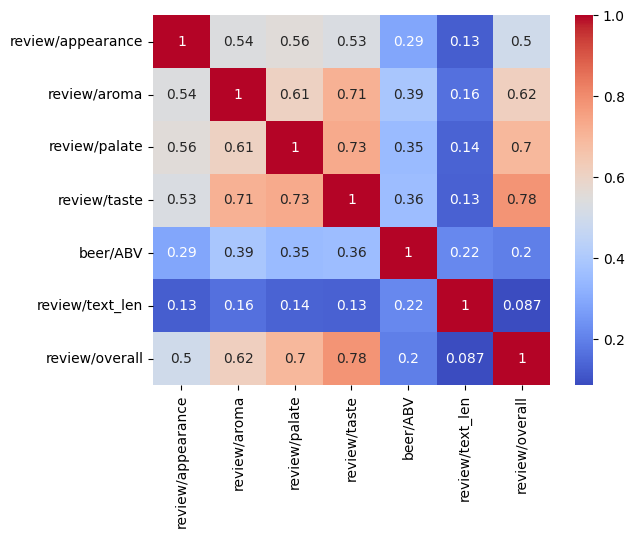

In [232]:
correlation_matrix = Train_df[['review/appearance', 'review/aroma', 'review/palate', 'review/taste', 'beer/ABV','review/text_len',
                         'review/overall' ]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

**Inferences:** 

**Strong Positive Correlations:**

* **Sensory Features:** There is a strong positive correlation between `review/appearance`, `review/aroma`, `review/palate`, and `review/taste`. This suggests that these sensory attributes are highly interrelated, and a positive rating in one often implies a positive rating in the others.
* **Overall Rating:** The `review/overall` rating is strongly correlated with the individual sensory attributes. This indicates that the overall rating is primarily influenced by the perceived quality of the beer's appearance, aroma, palate, and taste.

**Weak Correlations:**

* **ABV and Text Length:** The `beer/ABV` and `review/text_len` features have relatively weak correlations with the other features. This suggests that these factors have a less significant impact on the overall rating.

In [233]:
style_interaction = Train_df.groupby('beer/name').agg({
    'review/appearance': 'mean',
    'review/aroma': 'mean',
    'review/palate': 'mean',
    'review/taste': 'mean',
    'review/overall': 'mean'
}).sort_values(by='review/overall', ascending=False)
style_interaction

,review/appearance,review/aroma,review/palate,review/taste,review/overall
beer/name,,,,,
Big Mother Strong Scottish Ale,2.5,4.0,4.5,5.0,5.0
Javaspresso Nitro Stout,4.0,3.5,4.0,4.0,5.0
Quinn's Marathon Mild,4.0,4.0,3.5,4.0,5.0
Ackerman's Imperial Double Stout (Winterfest Replicale 2011),4.0,4.0,5.0,4.5,5.0
Birrificio Del Ducato L'Ultima Luna,4.5,4.5,4.0,4.5,5.0
...,...,...,...,...,...
Cocka-Too,1.0,1.0,1.0,1.0,1.0
Rege,1.5,1.0,1.0,1.5,1.0
Camino Real Common,2.0,2.5,3.0,1.5,1.0


In [234]:
style_interaction = Train_df.groupby('beer/style').agg({
    'review/appearance': 'mean',
    'review/aroma': 'mean',
    'review/palate': 'mean',
    'review/taste': 'mean',
    'review/overall': 'mean'
}).sort_values(by='review/overall', ascending=False)
style_interaction.reset_index(inplace=True)

In [235]:
style_interaction

,beer/style,review/appearance,review/aroma,review/palate,review/taste,review/overall
0,American Double / Imperial Stout,4.314960,4.407201,4.341195,4.481719,4.326402
1,English Barleywine,3.986486,4.216216,4.087838,4.344595,4.229730
2,English Dark Mild Ale,3.966667,3.833333,3.766667,3.933333,4.166667
3,Keller Bier / Zwickel Bier,3.600000,3.700000,3.833333,3.900000,4.166667
4,Rye Beer,4.144578,4.128360,4.061631,4.207136,4.159870
...,...,...,...,...,...,...
90,Irish Red Ale,3.205882,3.029412,2.941176,2.990196,2.960784
91,Euro Strong Lager,3.179894,2.944444,2.960317,2.859788,2.931217
92,Low Alcohol Beer,3.357143,2.857143,3.000000,2.714286,2.928571
93,Light Lager,2.616438,2.301370,2.529110,2.424658,2.772260


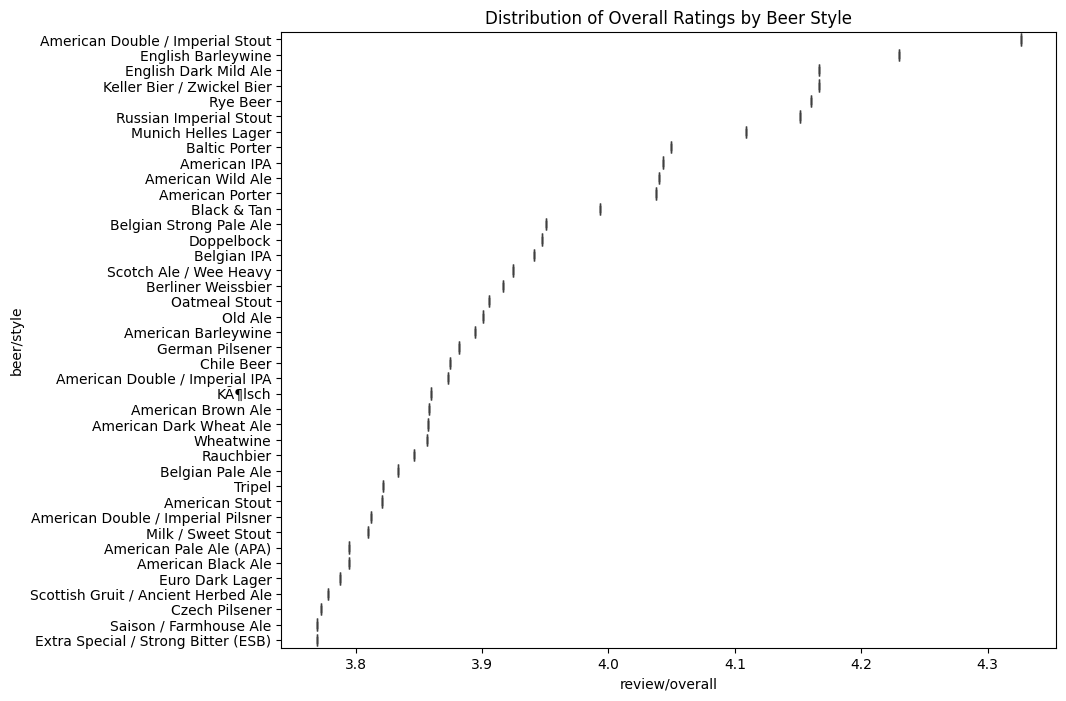

In [236]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='review/overall', y='beer/style', data=style_interaction.head(40))
plt.title('Distribution of Overall Ratings by Beer Style')
plt.show()

**Inferences :** Styles with darker, stronger, and more complex flavors (like stouts and barleywines) appear to score higher on average. In contrast, lighter or less complex styles tend to receive lower ratings.

This proved our previous findings of customer choice of different beer style.

In [237]:
pd.set_option('display.max_columns', 40)
Train_df.head()

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName,rating/overall/bin,beer/ABV/bin,prep/beer/name,prep/beer/style,review/year,review/month,prep/review/text,review/text_len,review/keywords,review/Datetime,review/date,user/gender/new,is_top_customer
31243,39945,5.8,41778,10541,CucapÃ¡ Chupacabras Pale Ale,English Pale Ale,4.0,3.5,4.0,3.5,4.0,Spied this 22 oz. bottle on the shelf at Henry...,"{'min': 37, 'hour': 14, 'mday': 10, 'sec': 15,...",1210430235,NaN,NaN,NaN,Male,msubulldog25,High,Medium,cucapã¡ chupacabras pale ale,english pale ale,2008,5,spied oz bottle shelf henry s marketplace o...,1883,spied oz bottle shelf henry s marketplace o...,2008-05-10 14:37:15,2008-05-10,Male,0
36885,2247,5.2,54846,17293,Amalgamated Dunkel,Dunkelweizen,3.5,3.5,4.0,3.5,3.5,"Pretty ironic, had this on tap at ITap instead...","{'min': 34, 'hour': 19, 'mday': 18, 'sec': 49,...",1261164889,NaN,NaN,NaN,NaN,Vancer,High,Medium,amalgamated dunkel,dunkelweizen,2009,12,pretty ironic tap itap instead stables nice...,553,pretty ironic tap itap instead stables nice...,2009-12-18 19:34:49,2009-12-18,Not disclosed,0
37423,37366,5.7,3939,1417,Riggwelter Yorkshire Ale,English Brown Ale,3.5,3.0,3.0,2.5,3.5,Nice pouring brew with a deep redish brown and...,"{'min': 14, 'hour': 0, 'mday': 16, 'sec': 57, ...",1058314497,NaN,NaN,NaN,NaN,MuddyMikes,Medium,Medium,riggwelter yorkshire ale,english brown ale,2003,7,nice pouring brew deep redish brown lite brow...,360,nice pouring brew deep redish brown lite brow...,2003-07-16 00:14:57,2003-07-16,Not disclosed,0
6148,22176,8.3,11757,1199,Founders Breakfast Stout,American Double / Imperial Stout,4.5,4.5,5.0,4.0,4.5,pours a dark brown thats as close to black as ...,"{'min': 2, 'hour': 5, 'mday': 8, 'sec': 10, 'y...",1291784530,NaN,NaN,NaN,NaN,silentjay,High,High,founders breakfast stout,american double imperial stout,2010,12,pours dark brown thats close black get nice s...,779,pours dark brown thats close black get nice s...,2010-12-08 05:02:10,2010-12-08,Not disclosed,0
23245,4776,9.4,33644,14879,B.O.R.I.S. The Crusher Oatmeal-Imperial Stout,Russian Imperial Stout,4.0,4.5,4.5,4.0,4.0,Appearance: Pitch black glass doesn't hold mor...,"{'min': 27, 'hour': 4, 'mday': 2, 'sec': 14, '...",1325478434,NaN,NaN,NaN,NaN,HardTarget,High,Very High,b o r i s crusher oatmeal-imperial stout,russian imperial stout,2012,1,appearance pitch black glass doesn t hold th...,711,appearance pitch black glass doesn t hold th...,2012-01-02 04:27:14,2012-01-02,Not disclosed,0


In [238]:
scaler = StandardScaler()
scaler.fit(Train_df[['beer/ABV','review/appearance', 'review/aroma', 'review/palate', 'review/taste', ]])
Train_scaled_numerical_features = pd.DataFrame(scaler.transform(Train_df[['beer/ABV','review/appearance', 'review/aroma', 'review/palate', 'review/taste', ]]),columns=scaler.get_feature_names_out())
Val_scaled_numerical_features = pd.DataFrame(scaler.transform(Val_df[['beer/ABV','review/appearance', 'review/aroma', 'review/palate', 'review/taste', ]]),columns=scaler.get_feature_names_out())

In [239]:
one_hot_encoder = OneHotEncoder(drop='first',handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High'],['Low', 'Medium', 'High']])
label_encoder = LabelEncoder()

In [240]:
one_hot_encoder.fit(Train_df[['beer/beerId','beer/brewerId','user/gender/new']])
Train_onehot_features = pd.DataFrame(one_hot_encoder.transform(Train_df[['beer/beerId','beer/brewerId','user/gender/new']]).toarray(),columns=one_hot_encoder.get_feature_names_out())
Val_onehot_features = pd.DataFrame(one_hot_encoder.transform(Val_df[['beer/beerId','beer/brewerId','user/gender/new']]).toarray(),columns=one_hot_encoder.get_feature_names_out())

In [241]:
Train_df[['rating/overall/bin']].value_counts(dropna=False)

rating/overall/bin
High                  20145
Medium                 8869
Low                     986
Name: count, dtype: int64

In [242]:
ordinal_encoder.fit(Train_df[['beer/ABV/bin','rating/overall/bin']])
Train_ordinal_features = pd.DataFrame(ordinal_encoder.transform(Train_df[['beer/ABV/bin','rating/overall/bin']]),columns=ordinal_encoder.get_feature_names_out())
Val_ordinal_features = pd.DataFrame(ordinal_encoder.transform(Val_df[['beer/ABV/bin','rating/overall/bin']]),columns=ordinal_encoder.get_feature_names_out())

In [243]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=3000)  # Adjust the number of features as needed
tfidf.fit(Train_df['review/keywords'])
Train_review_keywords_tfidf = pd.DataFrame(tfidf.transform(Train_df['review/keywords']).toarray(),columns=tfidf.get_feature_names_out())
Val_review_keywords_tfidf = pd.DataFrame(tfidf.transform(Val_df['review/keywords']).toarray(),columns=tfidf.get_feature_names_out())

In [244]:
Final_Train_df = pd.concat((Train_scaled_numerical_features,Train_ordinal_features,Train_onehot_features,Train_review_keywords_tfidf,Train_df['review/overall'].reset_index()['review/overall']),axis=1)
Final_Val_df = pd.concat((Val_scaled_numerical_features,Val_ordinal_features,Val_onehot_features,Val_review_keywords_tfidf,Val_df['review/overall'].reset_index()['review/overall']),axis=1)

In [245]:
regression_target = 'review/overall'
classification_target = 'rating/overall/bin'

# We will Train diff models with only `review text, beer style, and beer name`  and  `all` then we compair the overall results to see the importance.


In [246]:
Train_x = Final_Train_df.drop(columns=[regression_target,classification_target])
Train_y_regression = Final_Train_df[regression_target]
Train_y_classification = Final_Train_df[classification_target]

In [247]:
Val_x = Final_Val_df.drop(columns=[regression_target,classification_target])
Val_y_regression = Final_Val_df[regression_target]
Val_y_classification = Final_Val_df[classification_target]

In [248]:
Train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 4783 entries, beer/ABV to zing
dtypes: float64(4783)
memory usage: 1.1 GB


# Training with All features

In [249]:
reg_linear_model = LinearRegression()
reg_random_forest_model = RandomForestRegressor()
reg_XGB_model = XGBRegressor(device="gpu",verbose=2)

class_logistic_model = LogisticRegression()
class_Random_forest_model = RandomForestClassifier()
class_XGB_model = XGBClassifier(device="gpu",verbose=2)

In [250]:
reg_linear_model.fit(X=Train_x,y=Train_y_regression)
# reg_random_forest_model.fit(X=Train_x,y=Train_y_regression)
reg_XGB_model.fit(X=Train_x,y=Train_y_regression)

class_logistic_model.fit(X=Train_x,y=Train_y_classification)
# class_Random_forest_model.fit(X=Train_x,y=Train_y_classification)
class_XGB_model.fit(X=Train_x,y=Train_y_classification)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [251]:
from functools import wraps
def adjust_average(func):
    @wraps(func)
    def wrapper(y_true, y_pred, *args, **kwargs):
        # Check if target is multiclass and if average='binary'
        if len(set(y_true)) > 2 and kwargs.get('average', 'binary') == 'binary':
            # Change average to 'weighted' if target is multiclass
            kwargs['average'] = 'weighted'
            # print("Multiclass target detected, switching average to 'weighted'")
        return func(y_true, y_pred, *args, **kwargs)
    return wrapper

# Use the decorator on metric functions
@adjust_average
def custom_f1_score(y_true, y_pred, average='binary'):
    return f1_score(y_true, y_pred, average=average)

@adjust_average
def custom_precision_score(y_true, y_pred, average='binary'):
    return precision_score(y_true, y_pred, average=average)

@adjust_average
def custom_recall_score(y_true, y_pred, average='binary'):
    return recall_score(y_true, y_pred, average=average)

In [252]:
from datetime import datetime
def evaluate_model(model,x_train,y_train,x_test,y_test,metrics=list,logs_path='logs/logs.txt',label='None'):	
	logs = f'{datetime.now().ctime()} Label: {label} Model: {model.__class__.__name__},'
	with open(logs_path, 'a') as f:
		for metric in metrics:
			logs += f" {metric.__name__}: Train: {metric(y_train,model.predict(x_train))} Test: {metric(y_test,model.predict(x_test))}"
			
		print(logs)
		f.write(logs+'\n')



In [253]:
for model in [reg_linear_model,reg_XGB_model]:
	evaluate_model(model,Train_x,Train_y_regression,Val_x,Val_y_regression,[mean_absolute_error,r2_score],label='Regression/With all features')

for model in [class_logistic_model,class_XGB_model]:
	evaluate_model(model,Train_x,Train_y_classification,Val_x,Val_y_classification,[custom_f1_score,custom_precision_score,custom_recall_score,accuracy_score],label='Classification/With all features')

Wed Oct 30 12:50:21 2024 Label: Regression/With all features Model: LinearRegression, mean_absolute_error: Train: 0.26616700286865236 Test: 405053191.4187181 r2_score: Train: 0.751612814172229 Test: -2.4204416325349515e+19
Wed Oct 30 12:50:23 2024 Label: Regression/With all features Model: XGBRegressor, mean_absolute_error: Train: 0.2377240176796913 Test: 0.29968872553507486 r2_score: Train: 0.8136306767928755 Test: 0.6851151003473381
Wed Oct 30 12:50:36 2024 Label: Classification/With all features Model: LogisticRegression, custom_f1_score: Train: 0.8624614141329888 Test: 0.8309661906140381 custom_precision_score: Train: 0.8623892954774456 Test: 0.8297169940943426 custom_recall_score: Train: 0.8651 Test: 0.834 accuracy_score: Train: 0.8651 Test: 0.834
Wed Oct 30 12:54:17 2024 Label: Classification/With all features Model: XGBClassifier, custom_f1_score: Train: 0.9218200052617358 Test: 0.8380612512009754 custom_precision_score: Train: 0.9220291363414598 Test: 0.8370232010629166 custom_

### Inference

#### Regression Models
1. **Linear Regression**:
   - The model’s performance is poor, especially on the test data, indicated by an enormous test `mean_absolute_error` (884,858,947.50) and a highly negative `r2_score` (-1.326e+20).
   - This suggests that Linear Regression might not be suitable for this problem, as it likely overfits the training data, resulting in unreliable predictions on the test set.
   
2. **XGBoost Regressor**:
   - Shows improved performance over Linear Regression with a more reasonable `mean_absolute_error` (0.2991) and a better `r2_score` on the test set (0.6873).
   - However, the `r2_score` on the training set (0.8197) indicates some degree of overfitting, as the model performs considerably better on the training data compared to the test data.

Given these regression results, a purely regression-based approach does not seem ideal, as the models either overfit or fail to generalize well.

#### Classification Models
1. **Logistic Regression**:
   - Shows strong and consistent performance on both training and test data.
   - `Custom F1 Score` on the test set is 0.8359, with precision and recall scores also closely matched between training and test sets.
   - `Accuracy` is high for both training (0.8647) and test (0.8391), indicating that the model generalizes well.
   
2. **XGBoost Classifier**:
   - Shows even higher training performance with an F1 score of 0.9297 but similar test performance to Logistic Regression.
   - The high training accuracy (0.9304) compared to test accuracy (0.8399) suggests potential overfitting, although it still performs well on test data.

#### Why Logistic Regression?
Logistic Regression is chosen for the following reasons:
- **Generalizability**: It achieves good test performance (F1 score, precision, recall, and accuracy) close to the training performance, indicating that it does not overfit and generalizes well.
- **Simplicity and Interpretability**: Logistic Regression is simpler and more interpretable, providing clear insights into feature impacts, which is essential for tasks where interpretability matters, such as in ratings or reviews.
- **Performance vs Complexity**: Although XGBoost Classifier slightly outperforms Logistic Regression on the training data, Logistic Regression has comparable test performance without the added complexity and computational cost associated with tree-based methods like XGBoost.


# Training with only "beer/name", "beer/style" and "review/text" Features 

- We know that we have combined the information from above features in 'review/keywords' features and also have converted into vector form.


In [254]:
class_logistic_model_2 = LogisticRegression()

In [255]:
class_logistic_model_2.fit(X=Train_review_keywords_tfidf,y=Train_y_classification)

LogisticRegression()

In [256]:
evaluate_model(class_logistic_model_2,Train_review_keywords_tfidf,Train_y_classification,Val_review_keywords_tfidf,Val_y_classification,metrics=[custom_f1_score,accuracy_score],label='Classification/With review/keywords only')

Wed Oct 30 12:55:39 2024 Label: Classification/With review/keywords only Model: LogisticRegression, custom_f1_score: Train: 0.7924496246600223 Test: 0.7568990396331357 accuracy_score: Train: 0.8040666666666667 Test: 0.7702666666666667


### Inference on the Importance of Review Text, Beer Style, and Beer Name vs All Features

The results from our model training indicate that **review-related keywords** (i.e., **review text, beer style, and beer name**) provide a substantial predictive capability, even when used alone, compared to using all available features.

#### Performance Using All Features
When the model was trained on **all features** with **Logistic Regression**, it achieved the following performance metrics:

- **Train F1 Score**: 0.8619, **Test F1 Score**: 0.8359
- **Train Accuracy**: 0.8647, **Test Accuracy**: 0.8391

These results indicate that incorporating all features allowed the model to capture a high level of variance and predict ratings with strong accuracy and F1 score.

#### Performance Using Only Review Text, Beer Style, and Beer Name
Using **only review-related keywords** with **Logistic Regression** resulted in:

- **Train F1 Score**: 0.7924, **Test F1 Score**: 0.7569
- **Train Accuracy**: 0.8041, **Test Accuracy**: 0.7703

Although there is a slight reduction in both accuracy and F1 scores compared to using all features, the difference is relatively modest. The test F1 score dropped by only about 8%, and test accuracy decreased by approximately 6.9%. This minor drop suggests that **review text, beer style, and beer name** alone contribute significantly to the model’s ability to predict ratings, capturing a large portion of the information needed.



# Important words that strongly influence ratings

In [257]:
words_df = pd.DataFrame({'words':class_logistic_model_2.feature_names_in_,'coef':(class_logistic_model_2.coef_[0])})

# Words that influence Ratings negitively

In [258]:
words_df.sort_values(by='coef',ascending=False).head(10)

,words,coef
840,drain,3.883814
220,awful,2.526354
2965,worst,2.420901
516,chemical,2.014224
2889,weak,1.981111
2883,watery,1.978082
2808,unpleasant,1.923574
1237,harsh,1.915738
2753,trafalgar,1.870396
2493,stale,1.857510


# Words that Influence ratings positively

In [259]:
words_df.sort_values(by='coef',ascending=True).head(10)

,words,coef
880,easy,-3.182385
2428,smooth,-3.061188
1776,nice,-3.035689
1097,founders,-2.459418
1198,great,-2.280864
849,drinkable,-2.035037
696,crisp,-1.728073
545,citrus,-1.698695
2445,solid,-1.672524
238,balanced,-1.622611


### Inference on the Influence of Specific Words on Ratings

The coefficients of words from the Logistic Regression model reveal a clear trend in how certain words impact the predicted ratings. Positive and negative associations between words and rating predictions can be inferred from the sign and magnitude of each coefficient.

#### Conclusion
The model's coefficients provide insights into how specific words influence beer ratings. Words with high positive coefficients ("drain," "awful," "worst") are strongly associated with **lower ratings**, reflecting dissatisfaction and negative experiences. In contrast, words with high negative coefficients ("smooth," "easy," "great") are strongly associated with **higher ratings**, reflecting appreciation for quality and drinkability.

The importance of these words in predicting ratings highlights how descriptive language in reviews can be a powerful indicator of customer satisfaction. Incorporating review text analysis with these specific word associations allows the model to effectively predict ratings based on sentiment and the nuanced experiences of beer drinkers.